# We're going to add a background to our previous simple model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os
import sys

import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import arviz
import warnings
warnings.filterwarnings('ignore')

cpu = 'bear'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.sqr(tt.cos(i)))
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sqr(tt.sin(i)))
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.)))
        eps2 = tt.set_subtensor(eps2[1], (3./8.) * tt.sqr(tt.sin(2*i)))
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        return eps
            
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi = p

        # Unpack background parameters
        loga = phi[0]
        logb = phi[1]
        logc = phi[2]
        logd = phi[3]
        logj = phi[4]
        logk = phi[5]
        white = phi[6]
        scale = phi[7]
        nyq = phi[8]
        
        # Calculate the modes
        eps = self.epsilon(i)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
        self.modes *= self.get_apodization(nyq)
            
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)            
            
        #Create the model
        self.mod = self.modes + self.back
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    # Small separations are fractional
    def asymptotic(self, n, numax, alpha, epsilon, d=0.): 
        nmax = (numax / self.deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * self.deltanu

    def f0(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * tt.sqr((freq - numax)) / tt.sqr(w))

    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()
    
    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1        
        if theano:
            return height
        else:
            return height.eval()
    
    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2      
        if theano:
            return height
        else:
            return height.eval()
        
    def harvey(self, a, b, c):
        harvey = 0.9*tt.sqr(a)/b/(1.0 + tt.pow((self.f/b), c))
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return tt.sqr((tt.sin(x)/x))

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(tt.pow(10, loga), tt.pow(10, logb), 4.) \
                        +  self.harvey(tt.pow(10, logc), tt.pow(10, logd), 4.) \
                        +  self.harvey(tt.pow(10, logj), tt.pow(10, logk), 2.))\
                        +  white
        return background              

### Build the range

In [3]:
nmodes = 10
nbase = 13
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .1
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

### Build the frequencies

In [4]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [5]:
mod = model(ff, n0_, n1_, n2_, deltanu_)

In [6]:
init_f = [numax_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

In [7]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

### Reset model for new frequency range

In [8]:
mod = model(f, n0_, n1_, n2_, deltanu_)

### Build the linewidths

In [9]:
def kernel(n, rho, L):
    return rho**2 * np.exp(-0.5 * np.subtract.outer(n,n)**2 / L**2)

In [10]:
m_ = .5
c_ = .5
rho_ = 0.1
L_ = 0.3

fs = np.concatenate((f0_, f1_, f2_))
fs -= fs.min()
nf = fs/fs.max()
mu_ = m_ * nf + c_

Sigma_ = kernel(nf, rho_, L_)

lng0_ = np.random.multivariate_normal(mu_, Sigma_)
widths = [np.exp(lng0_)[0:len(f0_)],
          np.exp(lng0_)[len(f0_):len(f0_)+len(f1_)],
          np.exp(lng0_)[len(f0_)+len(f1_):]]

nf_ = nf[:,None]

### Build the mode amplitudes

In [22]:
w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 10.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
sigmaA_ = .2
amps = [np.abs(mod.A0(f0_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_),
        np.abs(mod.A1(f1_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_),
        np.abs(mod.A2(f2_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_)]

### Build the background

In [23]:
labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
phi_ =  [   1.6,   2.6,   1.6,   3.0,   1.7,   0.5,    0.4,     1., nyq]
phi_sigma = np.genfromtxt('phi_sigma.txt')
phi_cholesky = np.linalg.cholesky(phi_sigma)

### Construct the model

In [24]:
split_ = 1.
incl_ = np.pi/4.
init =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       phi_                           # background parameters
        ]
p = mod.model(init, theano=False)*np.random.chisquare(2., size=len(f))/2

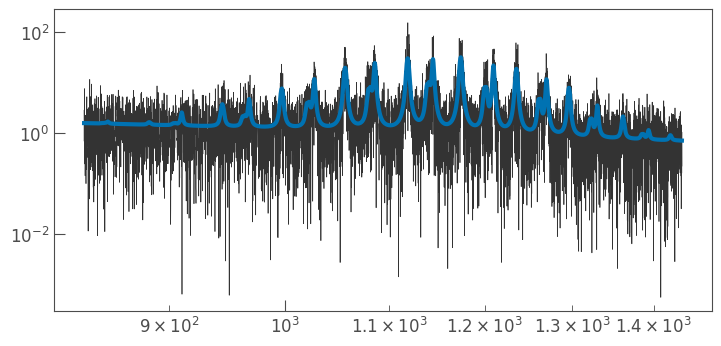

In [25]:
with plt.style.context(lk.MPLSTYLE):
    plt.plot(f, p)
    plt.plot(f, mod.model(init, theano=False), lw=3)
    plt.yscale('log')
    plt.xscale('log')
    if cpu == 'bear':
        plt.savefig('data.png')
    else: plt.show()

# Now lets try and fit this

In [26]:
pm_model = pm.Model()

with pm_model:   
    # Mode locations
    f0 = pm.Normal('f0', mu = f0_, sigma = sigma0_*10., testval = f0_, shape = len(f0_))
    f1 = pm.Normal('f1', mu = f1_, sigma = sigma1_*10., testval = f1_, shape = len(f1_))
    f2 = pm.Normal('f2', mu = f2_, sigma = sigma2_*10., testval = f2_, shape = len(f2_))

     # Mode linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init[3], shape=len(init[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init[4], shape=len(init[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init[5], shape=len(init[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=amps[0], shape=len(amps[0]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=amps[1], shape=len(amps[1]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=amps[2], shape=len(amps[2]))
    
    h0 = pm.Deterministic('h0', 2*tt.sqr(a0)/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*tt.sqr(a1)/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*tt.sqr(a2)/np.pi/g2)
    
    # Mode splitting
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init[9] * np.sin(init[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    # Background treatment
    phi = pm.MvNormal('phi', mu=phi_, chol=phi_cholesky, testval=phi_, shape=len(phi_))
    
    # Construct model
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [27]:
for RV in pm_model.basic_RVs:
    print(RV.name, RV.logp(pm_model.test_point))

f0 -36.26988734306884
f1 -39.14670806758664
f2 -25.283764456387733
g0_log__ -7.641216206713506
g1_log__ -7.742381360086984
g2_log__ -7.618975960735517
a0_log__ -19.499194279668504
a1_log__ -18.10655046286151
a2_log__ -23.07845321506442
xsplit_log__ -1.3280121234846454
cosi_interval__ -1.5745207675794886
phi 32.08864514052494
like -9794.633491909502


In [28]:
start = {'f0' : f0_, 'f1' : f1_, 'f2' : f2_,
        'xsplit' : split_ * incl_, 'cosi' : np.cos(incl_), 'phi' : phi_,
        'g0' : widths[0], 'g1' : widths[1], 'g2' : widths[2],
        'a0' : amps[0], 'a1' : amps[1], 'a2' : amps[2]}

In [29]:
with pm_model:
    trace = pm.sample(chains=4,
                        target_accept=.99,
                        start = start,
                     init = 'advi+adapt_diag',
                     progressbar=True)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 9,984.8:  77%|███████▋  | 153894/200000 [52:43<11:27, 67.08it/s]   
INFO:pymc3.variational.inference:Convergence achieved at 153900
INFO:pymc3.variational.inference:Interrupted at 153,899 [76%]: Average Loss = 35,949


TypeError: function() got an unexpected keyword argument 'n'

In [ ]:
pm.summary(trace)

In [ ]:
labels = ['xsplit','cosi','split','i']
chain = np.array([trace[label] for label in labels])
truths = [init[9] * np.sin(init[10]), np.cos(init[10]), init[9], init[10]]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
if cpu == 'bear':
    plt.savefig('corner.png')
else: plt.show()

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','phi']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    if cpu == 'bear':
        plt.savefig('modelfit.png')
    else: plt.show()

In [ ]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

phichain = np.array([trace['phi'][:,idx] for idx in range(len(phi_))]).T
truth = phi_

corner.corner(phichain, truths=truth, show_titles=True, labels=verbose)
if cpu == 'bear':
    plt.savefig('backcorner.png')
else: plt.show() 

In [ ]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

In [ ]:
sys.exit()